**ROBERTA GAROFANO**

**Deep Learning and Artificial Neural Networks Project.**






In this notebook, I address the problem of image classification and object detection, a significant task in the field of computer vision that involves predicting the class of an image and identifying the bounding box coordinates of the main object within the image. Specifically, I work with a dataset comprising 186 images categorized into three classes based on the primary object they contain. The dataset provides the following inputs for each image:

Input Image: A 227 × 227 × 3 real-valued tensor, where the last dimension denotes the number of input channels (RGB), with each pixel having a value in [0, 255].

Image Label: An integer in the set {1, 2, 3} indicating the class of the object within the image. The distribution includes 63 images in class 1, 62 images in class 2, and 61 images in class 3.

Image Bounding Box: Four integers x1, y1, x2, y2 in the range 1–227, representing the bottom-left (x1, y1) and top-right (x2, y2) corners of the bounding box surrounding the object.

Objective:

The primary objective of this project is to design and implement a deep neural network model capable of accurately predicting the class of an image and the corresponding bounding box coordinates (multi-task).

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import urllib.request
import zipfile
from sklearn.preprocessing import MinMaxScaler
import pickle as pk
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
import gc
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


'''seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)'''

# Load and preprocess data
# ZIP data URL from GitHub
zip_url = "https://github.com/Rob1602/DL-project-dataset/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
# Then use the following lines to read it:
with open(data_path, 'rb') as f:
    data = pk.load(f)
images = data['imgs']
y = data['labels']
labels = y[:, 0]
bboxes = y[:, 1:]

**MODEL**

I approach this problem using CNN architecture.
I consider this a multi-task problem since we need to classify the image along with the corresponding bounding box coordinates.
My objective is to create a model that saves computational space and effort by sharing the same parameters to extract both task features
.   


First of all, I print the shape of the dataset

In [ ]:
import numpy as np

# Print the shape of the images
print("Shape of images:", np.array(images).shape)

# Print the shape of the labels
print("Shape of labels:", labels.shape)

# Print the shape of the bounding boxes
print("Shape of bounding boxes:", bboxes.shape)


Shape of images: (186, 227, 227, 3)
Shape of labels: (186,)
Shape of bounding boxes: (186, 4)


**INPUT**

I consider as input the 227x227x3 image.

I will also need the image label of the set {1,2,3} denoting one of the possible object an image can contain, and the image bounding box coordinates of its bottom-left corner and top-right corner.






**Preprocessing**

**1)**I apply a MinMax scaler to the pixels values. In this way the pixels values of the tensor will be transformed from [0,255] to [0,1].
I also decided to implement data augumentation to ensure better generalization capabilities by the model.

**2)**I apply a min max to the image bounding box coordinates of its bottom-left corner and top-right corner, transforming the values from 1-227 to the range 0-1

**3)**Converting labels values to zero-indexed and to one-hot encoding is essential to properly format the labels for model training and for the model to correctly work. This avoids implicit ordering between classes and makes the labels compatible with the categorical cross-entropy loss function.




**1)**

I plot the first image of the dataset, to see how the image appears without pixel value normalization:


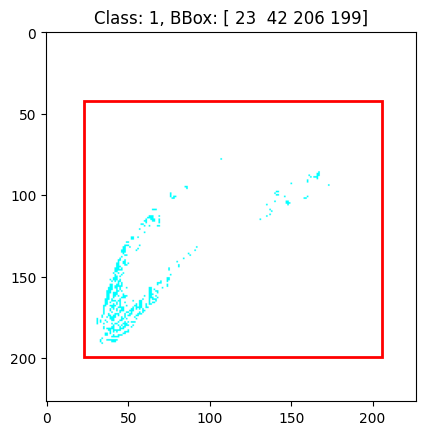

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#Plot the first image of the dataset
fig, ax = plt.subplots(1)
ax.imshow(images[0])

#Extraction of the class and the bounding box coordinates for the first sample of the dataset
class_label = labels[0]
bbox = bboxes[0]  # [x1, y1, x2, y2]

# Draw the bounding box onthe first image
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

#Plotting
plt.title(f'Class: {class_label}, BBox: {bbox}')
plt.show()


Then I normalize the values of the pixels with MinMaxScaler. I also print some random images  to understand it the tranformation have a good result and understand, just for curiosity, what the tree categories are about (cucumber, eggplant and mushroom).

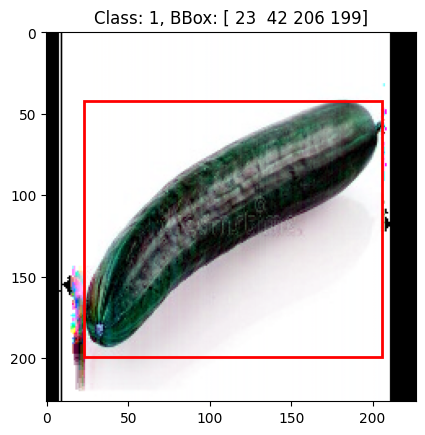

(227, 227, 3)
np.max(new_image_0): 1.000000238418579, np.max(images[0]): 255.0


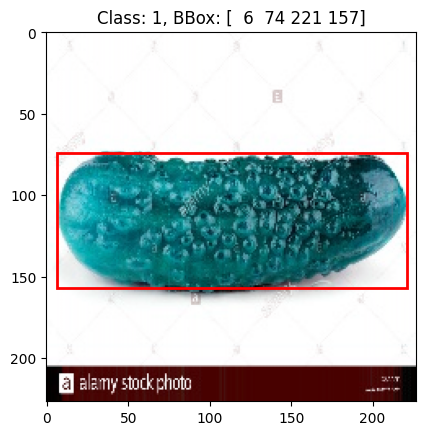

(227, 227, 3)
np.max(new_image_11): 1.0000001192092896, np.max(images[11]): 255.0


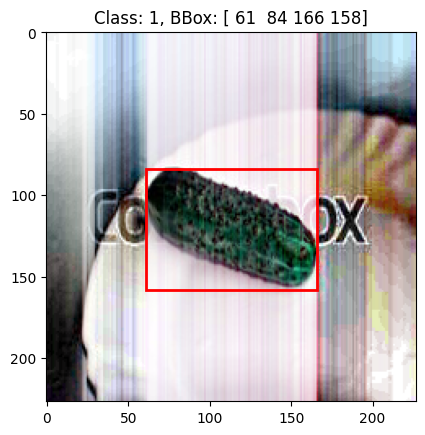

(227, 227, 3)
np.max(new_image_50): 1.0000009536743164, np.max(images[50]): 255.0


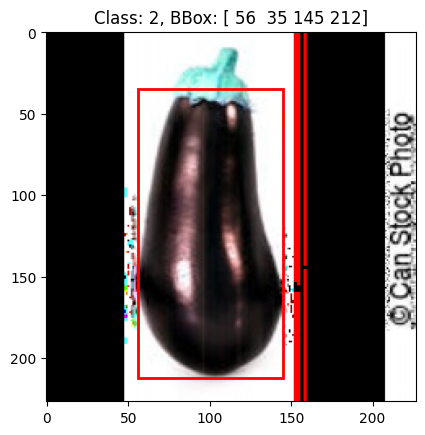

(227, 227, 3)
np.max(new_image_100): 1.0000001192092896, np.max(images[100]): 255.0


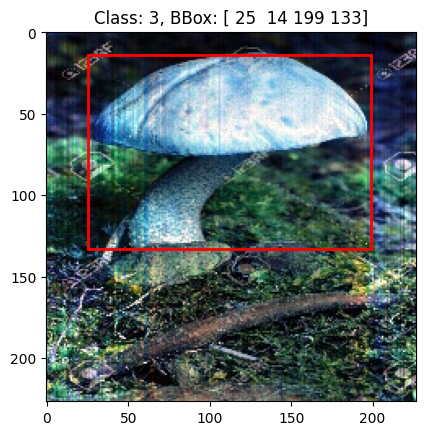

(227, 227, 3)
np.max(new_image_150): 1.0000001192092896, np.max(images[150]): 255.0


In [ ]:
import numpy as np
import matplotlib.patches as patches
from sklearn.preprocessing import MinMaxScaler

# Assume that 'images', 'labels', and 'bboxes' contain the images, classes, and bounding box coordinates loaded from the dataset

# Create a new array for the normalized images
images_scaled = np.zeros_like(images)

# Initialize the MinMaxScaler for values between 0 and 1
mmscaler = MinMaxScaler()

# Apply the MinMaxScaler to each image individually
for i in range(images.shape[0]):
    # Apply the MinMaxScaler to channels 0, 1, and 2 of each image
    for j in range(images.shape[3]):
        images_scaled[i, :, :, j] = mmscaler.fit_transform(images[i, :, :, j])

# Function to display image with bounding box
def display_image_with_bbox(image, bbox, class_label):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title(f'Class: {class_label}, BBox: {bbox}')
    plt.show()

# Print the first normalized image
new_image_0 = images_scaled[0]
class_label_0 = labels[0]
bbox_0 = bboxes[0]
display_image_with_bbox(new_image_0, bbox_0, class_label_0)
print(new_image_0.shape)
print(f"np.max(new_image_0): {np.max(new_image_0)}, np.max(images[0]): {np.max(images[0])}")


new_image_11 = images_scaled[11]
class_label_11 = labels[11]
bbox_11 = bboxes[11]
display_image_with_bbox(new_image_11, bbox_11, class_label_11)
print(new_image_11.shape)
print(f"np.max(new_image_11): {np.max(new_image_11)}, np.max(images[11]): {np.max(images[11])}")

new_image_50 = images_scaled[50]
class_label_50 = labels[50]
bbox_50 = bboxes[50]
display_image_with_bbox(new_image_50, bbox_50, class_label_50)
print(new_image_50.shape)
print(f"np.max(new_image_50): {np.max(new_image_50)}, np.max(images[50]): {np.max(images[50])}")



new_image_100 = images_scaled[100]
class_label_100 = labels[100]
bbox_100 = bboxes[100]
display_image_with_bbox(new_image_100, bbox_100, class_label_100)
print(new_image_100.shape)
print(f"np.max(new_image_100): {np.max(new_image_100)}, np.max(images[100]): {np.max(images[100])}")

new_image_150 = images_scaled[150]
class_label_150 = labels[150]
bbox_150 = bboxes[150]
display_image_with_bbox(new_image_150, bbox_150, class_label_150)
print(new_image_150.shape)
print(f"np.max(new_image_150): {np.max(new_image_150)}, np.max(images[150]): {np.max(images[150])}")



I implemented data augmentation. For each class, I generated 200 augmented images. This decision was based on the need to sufficiently expand the dataset to introduce more variability and to provide the model with a richer set of examples for training.
The augmented images are produced using a variety of transformations:
rotation, width and height, shifts, zoom, horizontal flip.
For each augmented image, the corresponding bounding box coordinates are adjusted to match the transformations applied to the image.

The augmented images, along with their adjusted bounding boxes and labels, are combined with the original dataset. This results in a larger and more diverse training set.


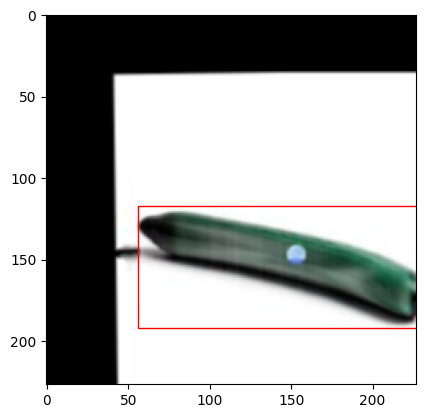

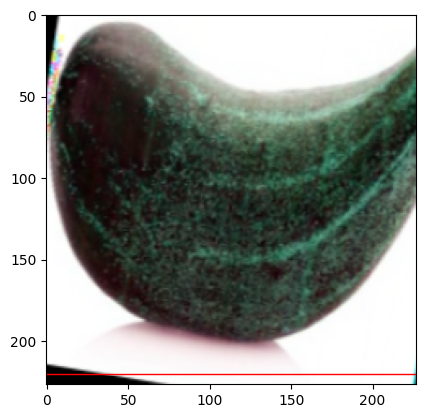

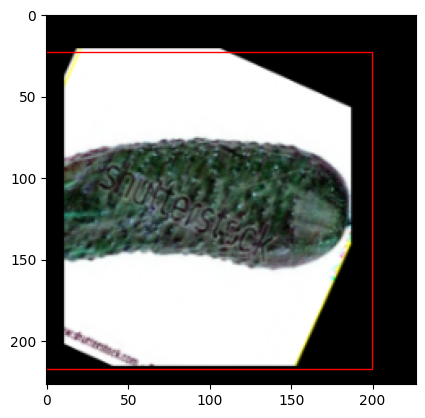

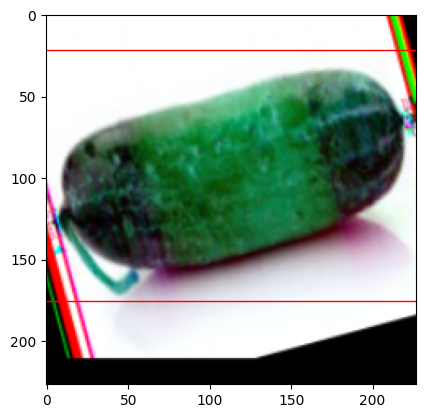

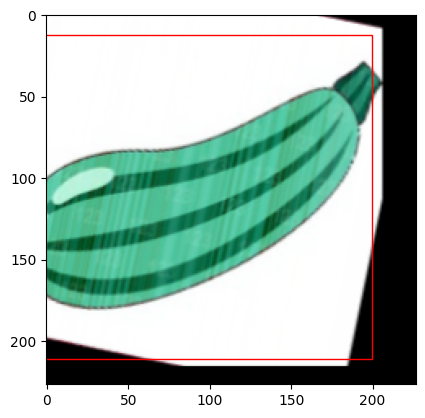

In [ ]:
import numpy as np
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def augment_image_and_bboxes(image, bboxes, seq):
    # Convert bounding boxes to the required format
    bbs = BoundingBoxesOnImage([BoundingBox(*bbox) for bbox in bboxes], shape=image.shape)
    # Apply augmentation
    augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)
    # Convert bounding boxes back to the required format
    new_bboxes = [[bbox.x1, bbox.y1, bbox.x2, bbox.y2] for bbox in augmented_bbs.bounding_boxes]
    return augmented_image, new_bboxes

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Augmentation sequence for bounding boxes
seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
    iaa.Affine(scale=(0.8, 1.2)),
    iaa.Fliplr(0.5)
])



augmented_images = []
augmented_bboxes = []
augmented_labels = []

num_augmentations_per_class = 200

for class_label in [1, 2, 3]:
    class_indices = np.where(labels == class_label)[0]
    class_images = images_scaled[class_indices]
    class_bboxes = bboxes[class_indices]

    for i in range(num_augmentations_per_class):
        # Choose a random image
        random_index = np.random.randint(0, len(class_images))
        image = class_images[random_index]
        bbox = [class_bboxes[random_index]]

        # Generate the aug img
        augmented_image, new_bboxes = augment_image_and_bboxes(image, bbox, seq)
        augmented_images.append(augmented_image)
        augmented_bboxes.append(new_bboxes[0])
        augmented_labels.append(class_label)

# Conversion in array numpy
augmented_images = np.array(augmented_images)
augmented_bboxes = np.array(augmented_bboxes)
augmented_labels = np.array(augmented_labels)

# Combining the original dataset and the new images
combined_images = np.concatenate((images_scaled, augmented_images), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)
combined_bboxes = np.concatenate((bboxes, augmented_bboxes), axis=0)



#Let's visualize a few new images
def show_image_with_bboxes(image, bboxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

for i in range(5):
    show_image_with_bboxes(augmented_images[i], [augmented_bboxes[i]])

Let's check shape of the new dataset is as expected

In [ ]:

unique_labels, counts = np.unique(combined_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Numero di immagini per la classe {label}: {count}")

Numero di immagini per la classe 1: 263
Numero di immagini per la classe 2: 262
Numero di immagini per la classe 3: 261


2) I apply MinMaxScaler to the bounding boxes coordinates and check the results.

In [ ]:

bbox_scaler = MinMaxScaler()
combined_bboxes_reshaped = combined_bboxes.reshape(-1, 4)
bbox_scaler.fit(combined_bboxes_reshaped)
combined_bboxes_normalized = bbox_scaler.transform(combined_bboxes_reshaped)
combined_boundboxes = combined_bboxes_normalized.reshape(combined_bboxes.shape)

print("Sample normalized bounding boxes:\n", combined_boundboxes[:5])

Sample normalized bounding boxes:
 [[0.36857537 0.52656036 0.54214295 0.46472268]
 [0.32969823 0.66758494 0.59520818 0.27564765]
 [0.31025966 0.52656036 0.60337206 0.46957076]
 [0.36468765 0.65247516 0.59112624 0.26595149]
 [0.33747366 0.59707265 0.56663459 0.25625534]]


3) I convert labels to zero-indexed and to one-hot encoding and check the results.

In [ ]:

combined_labels_zero_indexed = combined_labels - 1
combined_labels_one_hot = tf.keras.utils.to_categorical(combined_labels_zero_indexed)
print("Sample one-hot encoded labels:\n", combined_labels_one_hot[:5])


Sample one-hot encoded labels:
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


**OUTPUT**

The output layer will be bifurcated.
It will be divided in :   
-one softmax layer made of 3 units (one for each possible class).The use of softmax activation function will output a probability distribution, showing the model confidence in assigning each class.

-layer made of 4 units(one for each coordinate) and will have the sigmoid as activation function, which is perfect for values in [0,1].



**LOSS**

Because of the binary nature of the output, I use two different loss functions:

-for the classification I use a categorical cross entropy function, which is perfect for classification tasks, because it computes the dissimilarities between the true probability distribution and the predicted one.

-for the bounding box coordinates output, I use a MSE loss function.

**MODEL CONFIGURATION**

My model will have:
- first of all CNN layers, 'same' padding(I don’t want to loose information , even in the borders), max pooling (to extract the most meaningful features). The output of the convolutional /pooling layers to be flattened (in 1D)to feed the subsequent dense (fully connected layer) layer(s);

- ReLu activation function for the convolutional layers and the dense layers;
- He initialization (since it works well with ReLu) for the weights, batch normalization and dropout layers;
- hyperparameters to be tuned: Number of CNN layers, number of pooling layers, number of filters (or kernels), number of dense layers, number of epochs, learning rate, batch size, stride, dropout rate.

I dynamically construct a CNN model based on input hyperparameters.

I implement a random_search to find the best combination of hyperparameters. It samples parameters trains a model with each combination, and evaluates it to identify the best-performing model based on validation loss.
To do this I define a grid of hyperparameters to explore, including the number of CNN and dense layers, filters, filter sizes, dropout rates, learning rates, epochs, batch sizes, and strides.
I will have as output the best hyperparameters found during the random search, which are the ones I am gonna use to train the model.

This approach ensures that the model is tuned for optimal performance through a comprehensive exploration of hyperparameters.

In [ ]:
# Split the dataset into training, validation, and test set
#I ensure that the stratify parameter is se to true
train_images, test_images, train_labels, test_labels, train_bboxes, test_bboxes = train_test_split(
    combined_images, combined_labels_one_hot, combined_boundboxes, test_size=0.2, stratify=combined_labels, random_state=42)
train_images, val_images, train_labels, val_labels, train_bboxes, val_bboxes = train_test_split(
    train_images, train_labels, train_bboxes, test_size=0.2, stratify=np.argmax(train_labels, axis=1), random_state=42)

In [ ]:
from sklearn.model_selection import ParameterSampler
#function to create the model with dynamic params
def create_model(input_shape, num_cnn_layers, num_filters, filter_size, num_dense_layers, dropout_rate, stride):
    inputs = Input(shape=input_shape)
    x = inputs

    # Add Convolutional Layers
    for _ in range(num_cnn_layers):
        x = Conv2D(num_filters, (filter_size, filter_size), strides=stride, activation='relu', padding='same', kernel_initializer=HeNormal())(x)
        x = MaxPooling2D((2, 2))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    x = Flatten()(x)

    # Add Dense Layers
    for _ in range(num_dense_layers):
        x = Dense(128, activation='relu', kernel_initializer=HeNormal())(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Bifurcation for output layers
    class_output = Dense(3, activation='softmax', name='class_output', kernel_initializer=HeNormal())(x)
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output', kernel_initializer=HeNormal())(x)

    model = Model(inputs=inputs, outputs=[class_output, bbox_output])
    return model

# Definition of random search function
def random_search(train_images, train_labels, train_bboxes, val_images, val_labels, val_bboxes, param_grid, num_trials=10):
    best_model = None
    best_score = float('inf')
    best_params = None
    '''param_sampler = list(ParameterSampler(param_grid, n_iter=num_trials, random_state=seed))'''
    param_sampler = list(ParameterSampler(param_grid, n_iter=num_trials))
    for params in param_sampler:
        tf.keras.backend.clear_session()  # Clear the session
        model = create_model(
            input_shape=(227, 227, 3),
            num_cnn_layers=params['num_cnn_layers'],
            num_filters=params['num_filters'],
            filter_size=params['filter_size'],
            num_dense_layers=params['num_dense_layers'],
            dropout_rate=params['dropout_rate'],
            stride=params['stride']
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer,
                      loss={'class_output': tf.keras.losses.CategoricalCrossentropy(),
                            'bbox_output': tf.keras.losses.MeanSquaredError()},
                      metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(
            train_images,
            {'class_output': train_labels, 'bbox_output': train_bboxes},
            validation_data=(val_images, {'class_output': val_labels, 'bbox_output': val_bboxes}),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            callbacks=[early_stopping],
            verbose=1
        )
        val_loss = model.evaluate(val_images, {'class_output': val_labels, 'bbox_output': val_bboxes}, verbose=0)[0]
        if val_loss < best_score:
            best_score = val_loss
            best_model = model
            best_params = params
    return best_model, best_params

#Parameters to explore
param_grid = {
    'num_cnn_layers': [2, 3, 4],
    'num_filters': [32, 64, 128],
    'filter_size': [3, 5],
    'num_dense_layers': [1, 2],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0001],
    'epochs': [50],
    'batch_size': [16, 32],
    'stride': [(1, 1), (2, 2)]
}
#Execute the random search on the entire set of training data

num_trials = 10  #I choose not to have an extremelly high number of trials to not have problems with the computational resources
best_model, best_params = random_search(train_images, train_labels, train_bboxes, val_images, val_labels, val_bboxes, param_grid, num_trials)


# Let's print the best params
print("Best parameters used for final training:")
print(f"Number of CNN layers: {best_params['num_cnn_layers']}")
print(f"Number of filters: {best_params['num_filters']}")
print(f"Filter size: {best_params['filter_size']}")
print(f"Number of Dense layers: {best_params['num_dense_layers']}")
print(f"Dropout rate: {best_params['dropout_rate']}")
print(f"Stride: {best_params['stride']}")
print(f"Learning rate: {best_params['learning_rate']}")
print(f"Batch size: {best_params['batch_size']}")
print(f"Epochs: {best_params['epochs']}")

#Training the model with the best parameters I found
final_model = create_model(
    input_shape=(227, 227, 3),
    num_cnn_layers=best_params['num_cnn_layers'],
    num_filters=best_params['num_filters'],
    filter_size=best_params['filter_size'],
    num_dense_layers=best_params['num_dense_layers'],
    dropout_rate=best_params['dropout_rate'],
    stride=best_params['stride']
)

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=optimizer,
                    loss={'class_output': tf.keras.losses.CategoricalCrossentropy(),
                          'bbox_output': tf.keras.losses.MeanSquaredError()},
                    metrics={'class_output': 'accuracy', 'bbox_output': 'mse'})

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')


history= final_model.fit(
    train_images,
    {'class_output': train_labels, 'bbox_output': train_bboxes},
    validation_data=(val_images, {'class_output': val_labels, 'bbox_output': val_bboxes}),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Upload the best model
final_model = tf.keras.models.load_model('best_model.h5')

Epoch 1/50
16/16 [==============================] - 12s 179ms/step - loss: 1.5033 - class_output_loss: 1.3893 - bbox_output_loss: 0.1140 - class_output_accuracy: 0.4861 - bbox_output_mse: 0.1140 - val_loss: 3.9152 - val_class_output_loss: 3.7445 - val_bbox_output_loss: 0.1708 - val_class_output_accuracy: 0.3333 - val_bbox_output_mse: 0.1708
Epoch 2/50
16/16 [==============================] - 1s 77ms/step - loss: 0.9738 - class_output_loss: 0.8645 - bbox_output_loss: 0.1092 - class_output_accuracy: 0.6474 - bbox_output_mse: 0.1092 - val_loss: 2.3083 - val_class_output_loss: 2.1948 - val_bbox_output_loss: 0.1136 - val_class_output_accuracy: 0.3730 - val_bbox_output_mse: 0.1136
Epoch 3/50
16/16 [==============================] - 1s 79ms/step - loss: 0.6577 - class_output_loss: 0.5548 - bbox_output_loss: 0.1029 - class_output_accuracy: 0.7829 - bbox_output_mse: 0.1029 - val_loss: 1.6547 - val_class_output_loss: 1.5779 - val_bbox_output_loss: 0.0768 - val_class_output_accuracy: 0.4603 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 6s 177ms/step - loss: 0.9961 - class_output_loss: 0.8944 - bbox_output_loss: 0.1016 - class_output_accuracy: 0.6394 - bbox_output_mse: 0.1016 - val_loss: 0.9976 - val_class_output_loss: 0.9503 - val_bbox_output_loss: 0.0474 - val_class_output_accuracy: 0.5635 - val_bbox_output_mse: 0.0474
Epoch 3/50
32/32 [==============================] - 6s 173ms/step - loss: 0.7007 - class_output_loss: 0.6050 - bbox_output_loss: 0.0957 - class_output_accuracy: 0.7550 - bbox_output_mse: 0.0957 - val_loss: 1.4321 - val_class_output_loss: 1.3803 - val_bbox_output_loss: 0.0518 - val_class_output_accuracy: 0.4206 - val_bbox_output_mse: 0.0518
Epoch 4/50
32/32 [==============================] - 5s 172ms/step - loss: 0.7328 - class_output_loss: 0.6399 - bbox_output_loss: 0.0928 - class_output_accuracy: 0.7510 - bbox_output_mse: 0.0928 - val_loss: 1.8751 - val_class_output_loss: 1.8247 - val_bbox_output_loss: 0.0504 - val_class_output_accuracy: 0.3571 - val_bbox_outp

Let's print the graphic of the model, to also have a visual representation of its architecture.

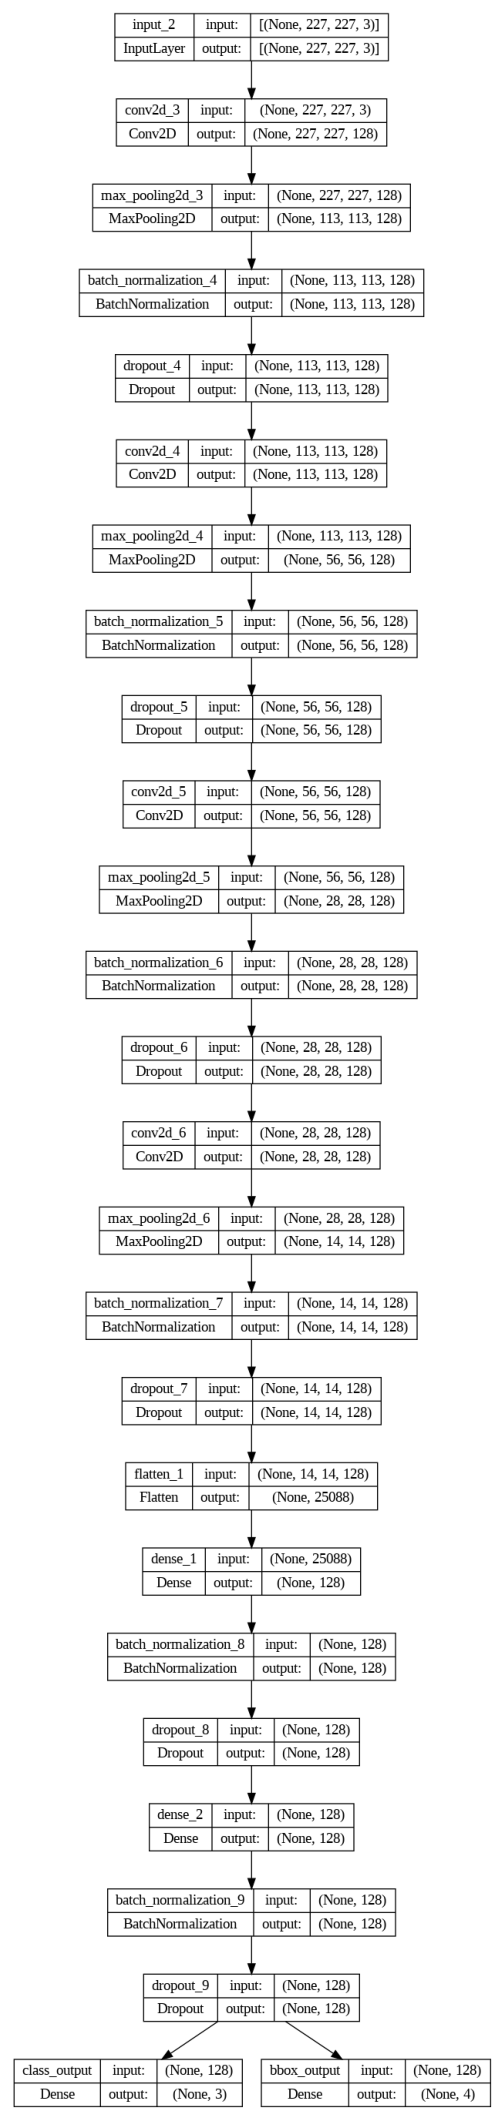

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image

final_model = tf.keras.models.load_model('best_model.h5')


plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


def display_model_plot(file_path):
    img = Image.open(file_path)
    plt.figure(figsize=(img.width / 100, img.height / 100), dpi=100)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

display_model_plot('model_plot.png')


**EVALUATION**

I have already splitted the dataset into train-validation(to motnitor the performance of the model during training) and test set (to understand how the model generalizes on unseen data).

Now, I also compute (and plot):
- the test class accuracy (test MSE for bbox), precision, recall and F1 score as metrics for objet classification
- the confusion matrix, understand the number of TP, TN, FP, FN for each class label (while I do not do it for bbox prdition since is a regression task where the model predicts continuous values for the coordinates)
-graphs to to compare the training and the validation along the epochs (I am implementing graps to observe genreral loss and class accuracy trends).


In [ ]:
# Evaluate the model on the test set
results = final_model.evaluate(test_images, {'class_output': test_labels, 'bbox_output': test_bboxes})

# Extract the relevant metrics
test_class_accuracy = results[3]  # Assuming the metrics are ordered as ['loss', 'class_output_loss', 'bbox_output_loss', 'class_output_accuracy', 'bbox_output_mse']
test_bbox_mse = results[4]

# Print the relevant metrics
print(f'Test Class Accuracy: {test_class_accuracy}')
print(f'Test BBox MSE: {test_bbox_mse}')


5/5 [==============================] - 1s 56ms/step - loss: 0.3876 - class_output_loss: 0.3558 - bbox_output_loss: 0.0318 - class_output_accuracy: 0.8671 - bbox_output_mse: 0.0318
Test Class Accuracy: 0.8670886158943176
Test BBox MSE: 0.03177774325013161


5/5 [==============================] - 0s 44ms/step


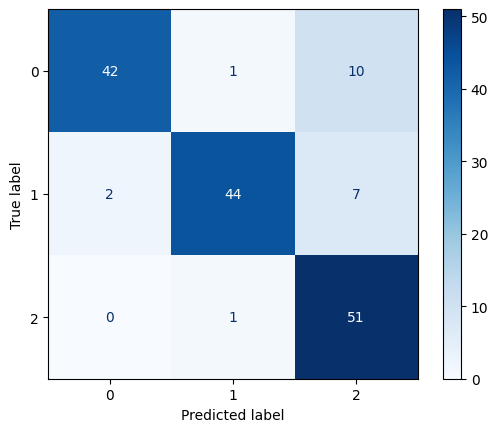

Precision: 0.89
Recall: 0.87
F1-Score: 0.87


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
#compute the predictions on the test set

test_predictions = final_model.predict(test_images)
test_class_predictions = np.argmax(test_predictions[0], axis=1)
#conversion from one hot to real class labels

test_class_labels = np.argmax(test_labels, axis=1)

#compute the confusion matrix
conf_matrix = confusion_matrix(test_class_labels, test_class_predictions)

#plot it
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# compute precision, recall e F1-score
precision = precision_score(test_class_labels, test_class_predictions, average='macro')
recall = recall_score(test_class_labels, test_class_predictions, average='macro')
f1 = f1_score(test_class_labels, test_class_predictions, average='macro')

#print the values
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


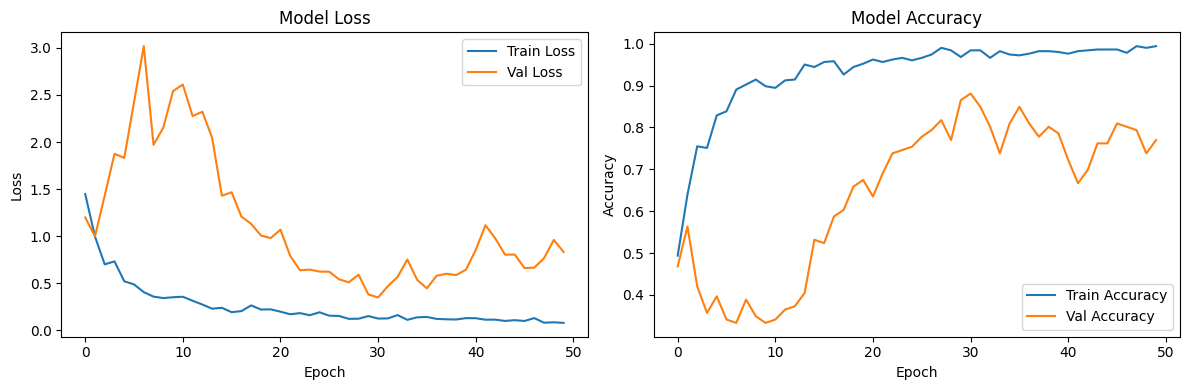

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot training & validation (general) loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values for class_output
plt.subplot(1, 2, 2)
plt.plot(history.history['class_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Now,  just for curiosity,  I wanto to observe how my model performs on an image downoladed from google images (a mushroom).

1/1 [==============================] - 1s 562ms/step
Class Predicted: 3
Bounding Box Predicted: [0.6600867  0.67169404 0.5614741  0.47261873]


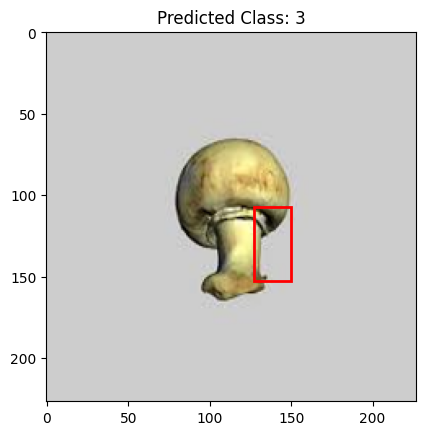

In [ ]:
import urllib.request
from PIL import Image
#uploading the URL of the image

test_image_url = "https://github.com/Rob1602/immagine_test/blob/main/fungo3.jpg?raw=true"

test_image_path = "temp/test_image.jpg"

# Download
urllib.request.urlretrieve(test_image_url, test_image_path)


def load_and_preprocess_image(image_path):

    image = Image.open(image_path)

    #resizing of the image
    image = image.resize((227, 227))

    # Conversion in numpy array
    image_array = np.array(image)

    # Normalize the image
    mmscaler = MinMaxScaler()
    image_array_scaled = np.zeros_like(image_array)
    for i in range(image_array.shape[2]):
        image_array_scaled[:, :, i] = mmscaler.fit_transform(image_array[:, :, i])

    #Adding a batch dim
    image_array_scaled = np.expand_dims(image_array_scaled, axis=0)

    return image_array_scaled

# Preprocessing
new_image = load_and_preprocess_image(test_image_path)

# Prediction
pred_class, pred_bbox = final_model.predict(new_image)

# Obtaining the class and the bounding box
pred_class = np.argmax(pred_class, axis=1) + 1
pred_bbox = pred_bbox[0]

print(f'Class Predicted: {pred_class[0]}')
print(f'Bounding Box Predicted: {pred_bbox}')

#Plot the results
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_pred_bbox(image_path, pred_bbox, pred_class):

    image = Image.open(image_path)
    image = image.resize((227, 227))


    image_array = np.array(image)


    fig, ax = plt.subplots(1)
    ax.imshow(image_array)

    # Draw the bbox
    rect = patches.Rectangle(
        (pred_bbox[0] * 227, pred_bbox[1] * 227),
        (pred_bbox[2] - pred_bbox[0]) * 227,
        (pred_bbox[3] - pred_bbox[1]) * 227,
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)

    #show the pred. class
    plt.title(f'Predicted Class: {pred_class}')
    plt.show()

# Display the image with the bbox
display_image_with_pred_bbox(test_image_path, pred_bbox, pred_class[0])


NOTE: I ran the model several times The best combination of parameters found by my random search is:

Number of CNN layers: 3

Number of filters: 128

Filter size: 5

Number of Dense layers: 1

Dropout rate: 0.5

Stride: (1, 1)

Learning rate: 0.001

Batch size: 16

Epochs: 50

For example, in this way I obtain:
Test Class Accuracy: 0.9367088675498962

Test BBox MSE: 0.011369435116648674

F1-Score: 0.94

...